# Imports

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.13.7 | packaged by conda-forge | (main, Sep  3 2025, 14:30:35) [GCC 14.3.0]
PyTorch version 2.6.0
Torchvision version 0.21.0
Numpy version 2.3.3
Pandas version 2.3.2


# Create Pytorch Dataset and Dataloader

In [52]:
# Create the playing card dataset class

class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self): # How many examples are in the dataset?
        return len(self.data)

    def __getitem__(self, idx): # Takes the index location in the dataset and returns one item.
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [53]:
# Name the data directory

data_dir = '/home/asunkari/neuro-ml/01_learn_pytorch/archive/train'

In [54]:
# Associate the numerical label value with the actual card name using a dictionary

target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [55]:
# Transform all images to the same size

transform = transforms.Compose([
    transforms.Resize((128, 128)),     # resize to 128px by 128px
    transforms.ToTensor(),             # convert the regular image (visual) to a tensor
])

In [56]:
# Import dataset

dataset = PlayingCardDataset(data_dir, transform)

In [57]:
# Dataloader setup

dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # choose batch size and whether to shuffle the data (better for training)

# PyTorch Model

In [58]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        # Where we define all the parts of the model.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) # remove last base layer from that model

        enet_out_size = 1280 # default number of outputs from efficient net b0
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes) # convert 1280 outputs into 53 classes

    def forward(self, x):
        # Connect these parts and return the output.
        x = self.features(x)
        output = self.classifier(x)
        return output

In [59]:
model = SimpleCardClassifier(num_classes=53)

for images, labels in dataloader:
    break

example_output = model(images)
example_output.shape

torch.Size([32, 53])

# Train the model

In [60]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion(example_output, labels)

tensor(4.0802, grad_fn=<NllLossBackward0>)

In [61]:
# transform again
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/train"
valid_folder = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/valid"
test_folder = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/test"

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [62]:
# simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cudo:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Epoch 1/5 - Train loss: 1.5822625131446943, Validation loss: 0.389460851111502


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


Epoch 2/5 - Train loss: 0.5565204840204273, Validation loss: 0.23915256644194982


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Epoch 3/5 - Train loss: 0.3487286731241132, Validation loss: 0.16801367863169256


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Epoch 4/5 - Train loss: 0.22116114301577694, Validation loss: 0.11045790787013073


Validation loop: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

Epoch 5/5 - Train loss: 0.2035427976943013, Validation loss: 0.18287086458701007


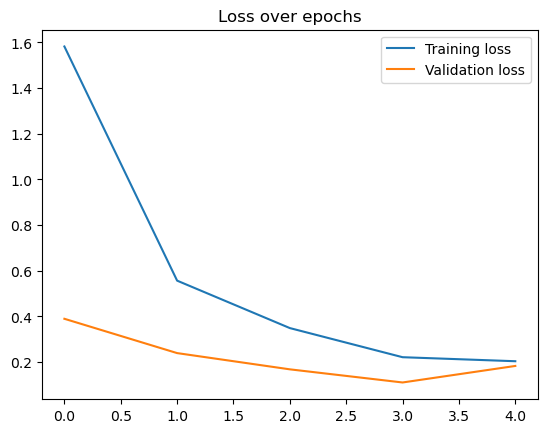

In [63]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

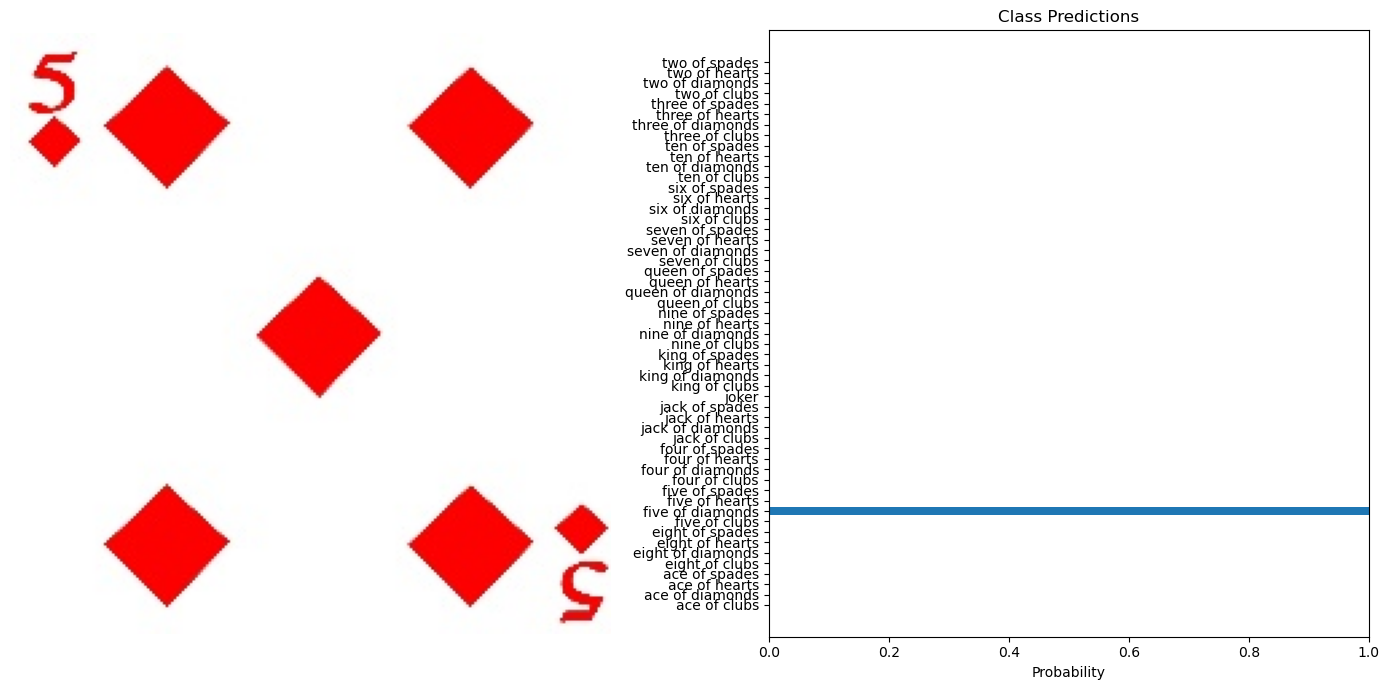

In [66]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/home/asunkari/neuro-ml/01_learn_pytorch/archive/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)